In [410]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


## In this notebook I am going to incorporate methods shown in the 9th chapter of the fastai fastbook

In [411]:
!pip install -Uqq dtreeviz
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import dtreeviz
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [412]:
import warnings
warnings.filterwarnings("ignore")

# Data analysis and cleanup

In [413]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv', low_memory=False)
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', low_memory=False)
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', low_memory=False)
df.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

### Ordinal columns

In [414]:
df_test['CAEC'].unique(), df_test['CALC'].unique()
df['CAEC'].unique(), df['CALC'].unique(), df['NObeyesdad'].unique()

(array(['Sometimes', 'Frequently', 'no', 'Always'], dtype=object),
 array(['Sometimes', 'no', 'Frequently'], dtype=object),
 array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
        'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
        'Obesity_Type_I'], dtype=object))

In [415]:
caec_order = ['no', 'Sometimes', 'Frequently', 'Always']
calc_order = ['no', 'Sometimes', 'Frequently']
obesity_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 
                 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 
                 'Obesity_Type_III']

df_test['CAEC'] = df_test['CAEC'].astype('category')
df_test['CALC'] = df_test['CALC'].astype('category')

df['CAEC'] = df['CAEC'].astype('category')
df['CALC'] = df['CALC'].astype('category')
df['NObeyesdad'] = df['NObeyesdad'].astype('category')

df_test['CAEC'] = df_test['CAEC'].cat.set_categories(caec_order, ordered=True)
df_test['CALC'] = df_test['CALC'].cat.set_categories(calc_order, ordered=True)

df['CAEC'] = df['CAEC'].cat.set_categories(caec_order, ordered=True)
df['CALC'] = df['CALC'].cat.set_categories(calc_order, ordered=True)
df['NObeyesdad'] = df['NObeyesdad'].cat.set_categories(obesity_order, ordered=True)

In [416]:
dep_var = 'NObeyesdad'

### TabularPandas 

In [417]:
procs = [Categorify, FillMissing]

In [418]:
splits = TrainTestSplitter(random_state=17)(range_of(df))

In [419]:
cont,cat = cont_cat_split(df, dep_var=dep_var)
cont, cat

(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'],
 ['Gender',
  'family_history_with_overweight',
  'FAVC',
  'CAEC',
  'SMOKE',
  'SCC',
  'CALC',
  'MTRANS'])

In [420]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train), len(to.valid)

(16606, 4152)

In [421]:
to.show(4)

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad
9210,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,9210,18.000000,1.792239,108.602715,2.0,2.449723,2.000000,1.000000,1.554404,Obesity_Type_I
20344,Male,no,yes,Sometimes,no,no,Sometimes,Public_Transportation,20344,21.000000,1.710000,70.000000,2.0,3.000000,1.000000,1.000000,1.000000,Normal_Weight
12078,Female,yes,yes,Sometimes,no,no,no,Public_Transportation,12078,21.000000,1.640000,63.000000,3.0,3.000000,3.000000,1.000000,0.000000,Normal_Weight
7456,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,7456,20.907833,1.792100,152.435623,3.0,3.000000,2.351193,1.999897,0.763359,Obesity_Type_III


In [422]:
to.items.head(4)

,id,Gender,Age,Height,...,TUE,CALC,MTRANS,NObeyesdad
9210,9210,2,18.000000,1.792239,...,1.554404,2,4,4
20344,20344,2,21.000000,1.710000,...,1.000000,2,4,1
12078,12078,1,21.000000,1.640000,...,0.000000,1,4,1
7456,7456,1,20.907833,1.792100,...,0.763359,2,4,6


### Creating the decision tree

In [423]:
type(xs)

pandas.core.frame.DataFrame

In [424]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [425]:
m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y);

In [426]:
xs.columns

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP',
       'CH2O', 'FAF', 'TUE'],
      dtype='object')

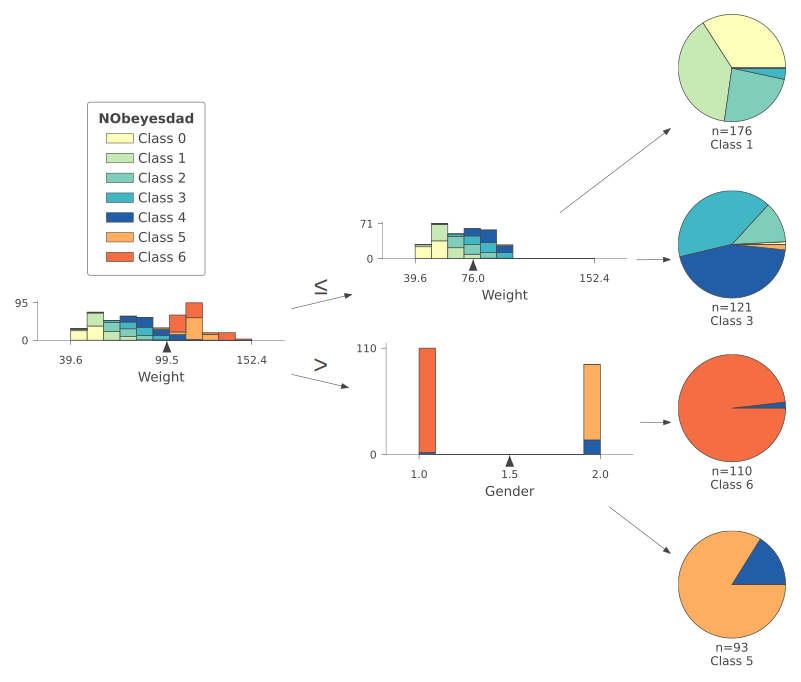

In [427]:
samp_idx = np.random.permutation(len(y))[:500]
viz = dtreeviz.model(m, xs.iloc[samp_idx], y.iloc[samp_idx], feature_names=xs.columns,
                     target_name=dep_var)
viz.view(scale=1.8, label_fontsize=10, orientation='LR')

In [428]:
# bigger tree
m = DecisionTreeClassifier()
m.fit(xs, y);

In [429]:
def m_acc(m, xs, y): return (m.predict(xs) == y).sum() / len(y)

In [430]:
m_acc(m, xs, y)

1.0

In [431]:
m_acc(m, valid_xs, valid_y)

0.8504335260115607

In [432]:
m.get_n_leaves(), len(xs)

(1886, 16606)

tree is overfitting training data, lets fix it

In [433]:
m = DecisionTreeClassifier(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_acc(m, xs, y)

0.8890762375045165

In [434]:
m_acc(m, valid_xs, valid_y)

0.8810211946050096

In [435]:
m.get_n_leaves()

322

much better*

### Random forest

In [436]:
def rf(xs, y, n_estimators=100, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
                                 max_features=max_features, min_samples_leaf=min_samples_leaf, 
                                 oob_score=True).fit(xs, y)

In [437]:
m = rf(xs, y);

In [438]:
m_acc(m, valid_xs, valid_y)

0.9034200385356455

In [439]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [440]:
def r_acc(preds, y): return (np.median(preds, axis=0) == y).sum() / len(y)

In [441]:
preds

array([[2., 2., 1., ..., 4., 6., 0.],
       [4., 1., 1., ..., 3., 6., 0.],
       [4., 2., 1., ..., 5., 6., 0.],
       ...,
       [4., 3., 1., ..., 4., 6., 0.],
       [4., 2., 1., ..., 3., 6., 0.],
       [4., 1., 1., ..., 3., 6., 0.]])

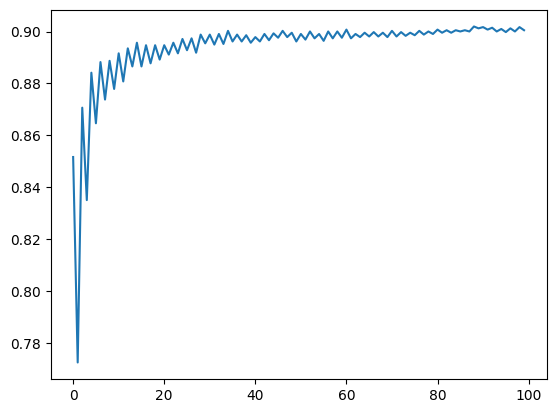

In [442]:
plt.plot([r_acc(preds[:i+1], valid_y) for i in range(100)]);

the improvement levels off after 30 trees

### Model interpretation

In [443]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [444]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
11,Weight,0.491748
10,Height,0.100800
0,Gender,0.100348
12,FCVC,0.092746
9,Age,0.072326
16,TUE,0.024336
14,CH2O,0.024270
1,family_history_with_overweight,0.018868
13,NCP,0.014936
8,id,0.012986


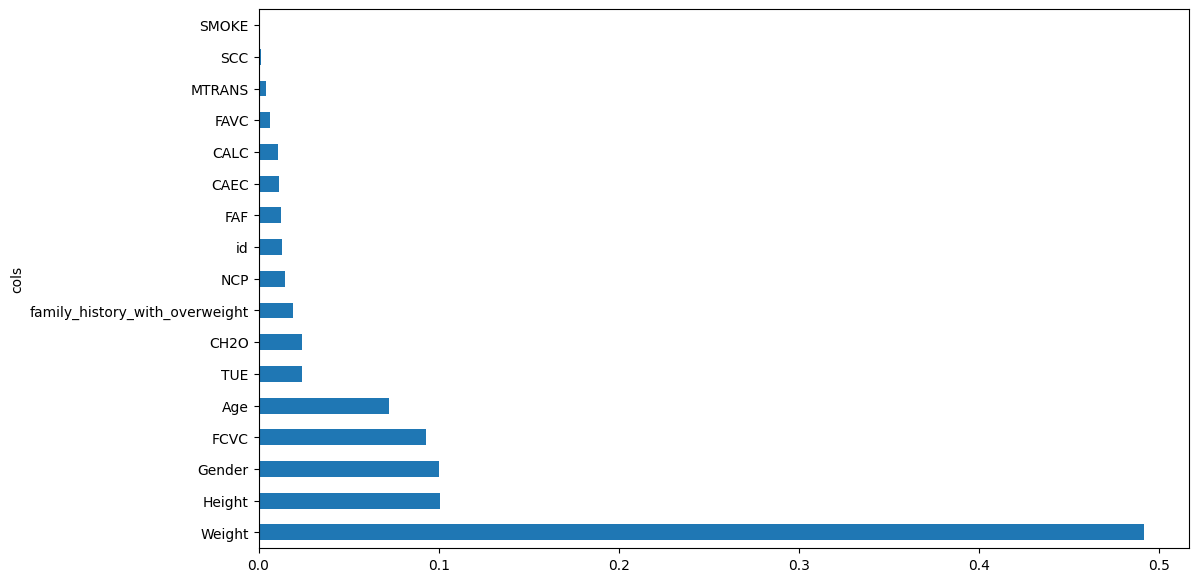

In [445]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);

Let's get rid of low importance features

In [446]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

14

In [447]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [448]:
m = rf(xs_imp, y)

In [449]:
# accuracy is about the same but we have less columns to study
m_acc(m, xs_imp, y), m_acc(m, valid_xs_imp, valid_y)

(0.9397205829218355, 0.9026974951830443)

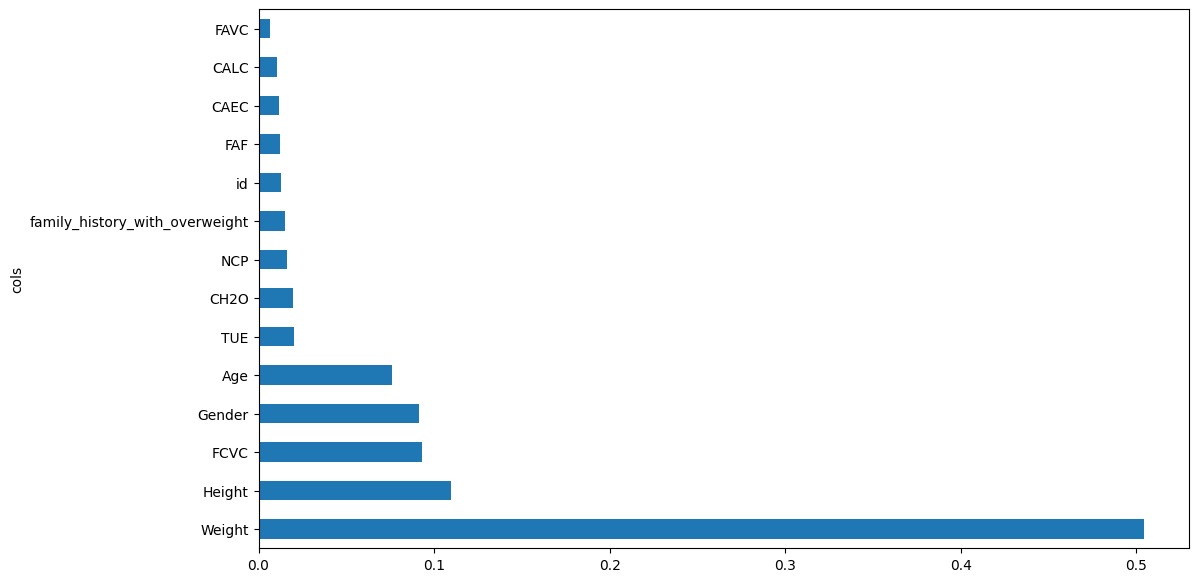

In [450]:
plot_fi(rf_feat_importance(m, xs_imp));

In [451]:
def get_oob(df):
    "A function that counts out of bag error"
    m = RandomForestClassifier(n_estimators=100, min_samples_leaf=5,
        max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [452]:
get_oob(xs_imp)

0.8963025412501505

In [453]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [454]:
m = rf(xs_final, y)
m_acc(m, valid_xs_final, valid_y)

0.9029383429672447

### Partial dependance

Let's analize the more important features

In [455]:
to.classes

{'Gender': ['#na#', 'Female', 'Male'],
 'family_history_with_overweight': ['#na#', 'no', 'yes'],
 'FAVC': ['#na#', 'no', 'yes'],
 'CAEC': ['#na#', 'no', 'Sometimes', 'Frequently', 'Always'],
 'SMOKE': ['#na#', 'no', 'yes'],
 'SCC': ['#na#', 'no', 'yes'],
 'CALC': ['#na#', 'no', 'Sometimes', 'Frequently'],
 'MTRANS': ['#na#', 'Automobile', 'Bike', 'Motorbike', 'Public_Transportation', 'Walking']}

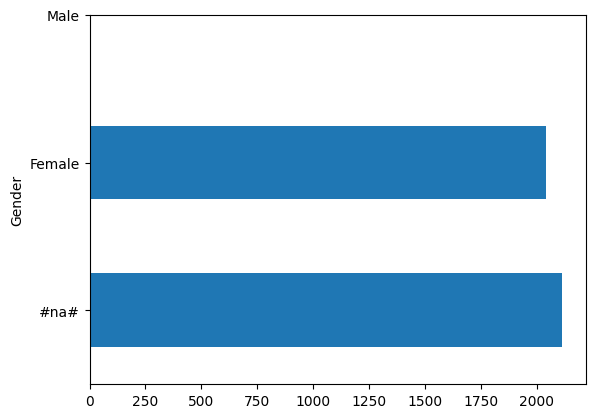

In [456]:
p = valid_xs_final['Gender'].value_counts(sort=False).plot.barh()
c = to.classes['Gender']
plt.yticks(range(len(c)), c);

it seems that fastai counted male values as #na, whatever it doesn't matter anyway

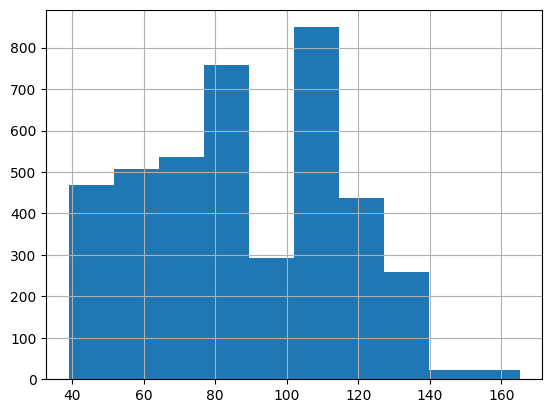

In [457]:
ax = valid_xs_final['Weight'].hist()

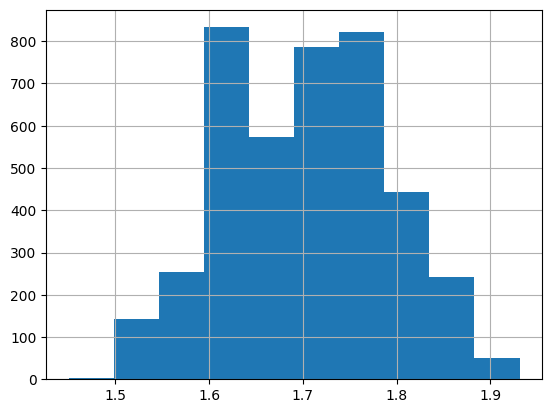

In [458]:
bx = valid_xs_final['Height'].hist()

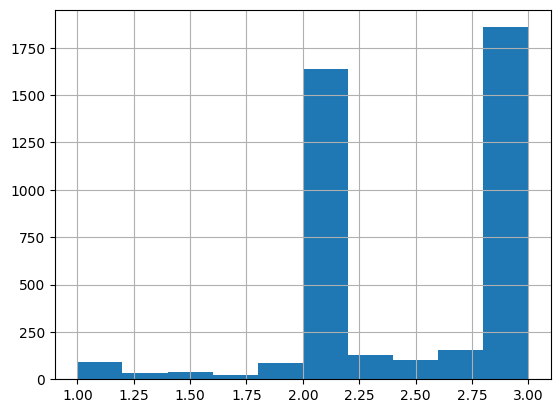

In [459]:
cx = valid_xs_final['FCVC'].hist()

I don't like this distribution, maybe i will do something about it later

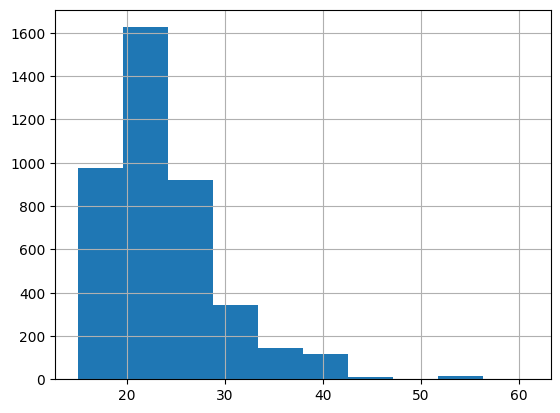

In [460]:
dx = valid_xs_final['Age'].hist()

### Finding Out-of-domain data

In [461]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
9,id,0.200222
1,Height,0.146974
0,Weight,0.140176
4,Age,0.112090
6,CH2O,0.089984
5,TUE,0.085266


In [462]:
m = rf(xs_final, y)
print('orig', m_acc(m, valid_xs_final, valid_y))

m = rf(xs_final.drop('id',axis=1), y)
print('id', m_acc(m, valid_xs_final.drop('id',axis=1), valid_y))

m = rf(xs_final.drop('FCVC',axis=1), y)
print('FCVC', m_acc(m, valid_xs_final.drop('FCVC',axis=1), valid_y))

orig 0.9039017341040463
id 0.901252408477842
FCVC 0.9019749518304432


Let's delete id

In [463]:
xs_final_time = xs_final.drop('id', axis=1)
valid_xs_time = valid_xs_final.drop('id', axis=1)

In [464]:
m = rf(xs_final_time, y)

# Neural Network and other enhancements

In [465]:
df_nn_final = df[list(xs_final_time.columns) + [dep_var]]

In [466]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [467]:
cont_nn

['Weight', 'Height', 'FCVC', 'Age', 'TUE', 'CH2O', 'NCP', 'FAF']

In [468]:
cat_nn

['Gender', 'family_history_with_overweight', 'CAEC', 'CALC', 'FAVC']

In [469]:
df_nn_final[cat_nn].nunique()

Gender                            2
family_history_with_overweight    2
CAEC                              4
CALC                              3
FAVC                              2
dtype: int64

In [470]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [471]:
dls = to_nn.dataloaders(1024)

In [472]:
learn = tabular_learner(dls, layers=[400,200], loss_func=CrossEntropyLossFlat(),
                        n_out=7, metrics=accuracy)

SuggestedLRs(valley=0.0008317637839354575)

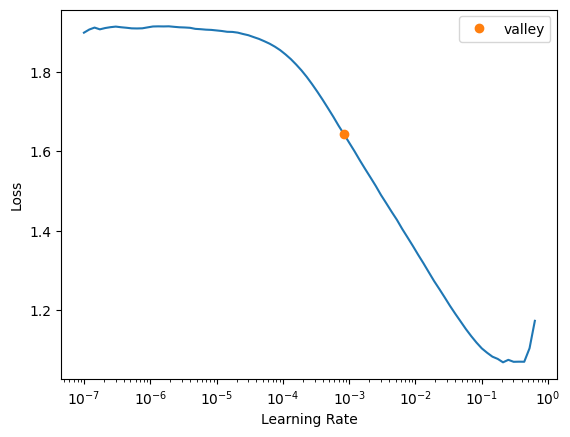

In [473]:
learn.lr_find()

In [474]:
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.062893,1.090779,0.711223,00:00
1,0.790398,0.468101,0.836946,00:00
2,0.625679,0.380515,0.866570,00:00
3,0.532570,0.386383,0.862717,00:00
4,0.475034,0.359229,0.867534,00:00
5,0.434893,0.356386,0.876927,00:00
6,0.406007,0.370678,0.872351,00:00
7,0.383002,0.360029,0.879817,00:00
8,0.364356,0.342222,0.874037,00:00
9,0.349922,0.345949,0.878854,00:00


Neural Network is performing worse than random forest

# First Submission (without ensembling)

In [475]:
m = rf(xs_final_time, y, n_estimators=10000)

In [476]:
m_acc(m, valid_xs_time, valid_y)

0.904383429672447

In [477]:
test = to.new(df_test)
test.process()

In [478]:
test_xs = test.train.xs
test_xs = test_xs[xs_final_time.columns]

In [480]:
preds = m.predict(test_xs)

In [481]:
mapping = dict(enumerate(to.vocab))
results = pd.Series(preds, name="labels").map(mapping)
results

0            Obesity_Type_II
1         Overweight_Level_I
2           Obesity_Type_III
3             Obesity_Type_I
4           Obesity_Type_III
                ...         
13835    Overweight_Level_II
13836     Overweight_Level_I
13837    Insufficient_Weight
13838          Normal_Weight
13839        Obesity_Type_II
Name: labels, Length: 13840, dtype: object

In [482]:
submission.head()

,id,NObeyesdad
0,20758,Normal_Weight
1,20759,Normal_Weight
2,20760,Normal_Weight
3,20761,Normal_Weight
4,20762,Normal_Weight


In [483]:
submission['NObeyesdad'] = results
submission

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [484]:
# submission.to_csv('submission_1.csv', index=False)

this scored me an accuracy of 0.89812 and a position 2441/3387

# Ensembling

In [485]:
rf_probabilities = m.predict_proba(test_xs)
rf_probabilities

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.91411954e-04, 9.99608588e-01, 0.00000000e+00],
       [1.98647186e-04, 3.44263527e-02, 9.22891029e-01, ...,
        2.02860002e-02, 0.00000000e+00, 4.60504202e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.54189881e-05, 3.58315287e-06, 9.99980900e-01],
       ...,
       [8.89848632e-01, 1.01320147e-01, 8.53194599e-03, ...,
        5.89285714e-05, 0.00000000e+00, 0.00000000e+00],
       [1.81328158e-01, 7.87888875e-01, 1.62025754e-02, ...,
        6.67678433e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.20689668e-03, 9.98793103e-01, 0.00000000e+00]])

In [489]:
test_dl = dls.test_dl(test_xs)
test_dl.show_batch()

,Gender,family_history_with_overweight,CAEC,CALC,FAVC,Weight,Height,FCVC,Age,TUE,CH2O,NCP,FAF
0,#na#,#na#,#na#,#na#,#na#,120.644179,1.848294,2.938616,26.899886,2.380717e-08,2.825629,3.000000,8.554000e-01
1,#na#,#na#,#na#,#na#,#na#,66.000001,1.600000,2.000000,21.000000,2.380717e-08,3.000000,1.000000,1.000000e+00
2,#na#,#na#,#na#,#na#,#na#,111.600553,1.643355,3.000000,26.000000,2.505020e-01,2.621877,3.000000,3.311855e-08
3,#na#,#na#,#na#,#na#,#na#,103.669115,1.553127,2.000000,20.979254,2.380717e-08,2.786417,2.977909,9.485096e-02
4,#na#,#na#,#na#,#na#,#na#,104.835346,1.627396,3.000000,26.000000,7.410690e-01,2.653531,3.000000,3.311855e-08
5,#na#,#na#,#na#,#na#,#na#,59.605028,1.844751,2.000000,19.799054,1.283673e+00,2.722063,4.000000,2.000000e+00
6,#na#,#na#,#na#,#na#,#na#,51.442294,1.728834,1.202075,18.000000,1.000000e+00,1.087166,3.000000,7.885850e-01
7,#na#,#na#,#na#,#na#,#na#,80.000000,1.810000,2.000000,20.000000,2.380717e-08,2.000000,3.000000,3.000000e+00
8,#na#,#na#,#na#,#na#,#na#,80.000000,1.700000,2.000000,21.000000,2.000000e+00,2.000000,3.000000,3.311855e-08
9,#na#,#na#,#na#,#na#,#na#,52.999999,1.560000,2.000000,21.000000,1.000000e+00,2.000000,3.000000,3.311855e-08


those #na# look really bad, maybe I will do something about it when I am done with submissions

In [490]:
nn_probabilities, _ = learn.get_preds(dl=test_dl)
nn_probabilities

tensor([[1.3334e-04, 2.4856e-05, 6.7104e-06,  ..., 3.7318e-02, 9.2747e-01,
         3.4967e-02],
        [4.3236e-04, 6.4332e-02, 9.1184e-01,  ..., 2.0775e-03, 1.4471e-05,
         3.6503e-05],
        [3.3051e-04, 1.9030e-05, 7.9673e-06,  ..., 3.8762e-02, 5.7014e-02,
         9.0246e-01],
        ...,
        [6.4285e-01, 3.5709e-01, 5.3761e-05,  ..., 2.6308e-10, 1.6431e-07,
         4.6413e-06],
        [1.1987e-01, 8.7696e-01, 3.1087e-03,  ..., 1.6153e-08, 7.8355e-07,
         9.4877e-06],
        [3.2314e-05, 7.9506e-06, 6.0346e-07,  ..., 1.2316e-02, 9.8358e-01,
         4.0427e-03]])

In [497]:
ensemble = torch.stack([torch.tensor(rf_probabilities), nn_probabilities])
ensemble.shape

torch.Size([2, 13840, 7])

In [502]:
ensemble = ensemble.mean(dim=0)
ensemble.shape

torch.Size([13840, 7])

In [505]:
ens_preds = torch.argmax(ensemble, dim=1).numpy()
ens_preds

array([5, 2, 6, ..., 0, 1, 5])

In [506]:
mapping = dict(enumerate(to.vocab))
results = pd.Series(ens_preds, name="labels").map(mapping)
results

0            Obesity_Type_II
1         Overweight_Level_I
2           Obesity_Type_III
3             Obesity_Type_I
4           Obesity_Type_III
                ...         
13835    Overweight_Level_II
13836          Normal_Weight
13837    Insufficient_Weight
13838          Normal_Weight
13839        Obesity_Type_II
Name: labels, Length: 13840, dtype: object

In [507]:
submission['NObeyesdad'] = results

In [508]:
# submission.to_csv('submission_2.csv', index=False)

this resulted in a public score 0.87463